In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from typing import Dict, Any, List

# --- Data Generation Parameters ---
PARAMS_A: Dict[str, Any] = {
    "n_events": 1000,
    "poisson_lam": 10.0,
    "xy_mean": np.array([0.0, 0.0]),
    "xy_cov": np.array([[4.0, 0.0], [0.0, 4.0]]),
    "z_mean": 1.0,
    "z_std": 0.5,
    "w_shape": 50.0,
    "w_scale": 1.0,
}

PARAMS_B: Dict[str, Any] = {
    "n_events": 1000,
    "poisson_lam": 6.0,
    "xy_mean": np.array([0.0, 0.0]),
    "xy_cov": np.array([[10.0, 0.0], [0.0, 10.0]]),
    "z_mean": 3.00,
    "z_std": 0.5,
    "w_shape": 25.0,
    "w_scale": 3,
}

def generate_toy_data_with_steps(params: Dict[str, Any]) -> pd.DataFrame:
    """Generates a toy dataset including the Euclidean step distance."""
    rng = np.random.default_rng()
    all_events_data = []

    for event_id in range(params["n_events"]):
        n_i = rng.poisson(lam=params["poisson_lam"])
        if n_i == 0:
            continue

        # Generate steps for the random walks
        xy_steps = rng.multivariate_normal(mean=params["xy_mean"], cov=params["xy_cov"], size=n_i)
        z_steps = rng.normal(loc=params["z_mean"], scale=params["z_std"], size=n_i)

        # Combine x, y, z steps into a single (n_i, 3) array
        xyz_steps = np.hstack([xy_steps, z_steps[:, np.newaxis]])
        
        # Calculate the Euclidean distance (L2 norm) of each step vector
        step_distance = np.linalg.norm(xyz_steps, axis=1)

        # Generate independent values for w
        w_values = rng.gamma(shape=params["w_shape"], scale=params["w_scale"], size=n_i)

        # Compute the random walk paths via cumulative sum
        xy_path = np.cumsum(xy_steps, axis=0)
        z_path = np.cumsum(z_steps)

        # Create a DataFrame for the current event from its components
        event_df = pd.DataFrame({
            'event_id': event_id,
            'x': xy_path[:, 0],
            'y': xy_path[:, 1],
            'z': z_path,
            'w': w_values,
            'd': step_distance
        })
        all_events_data.append(event_df)

    if not all_events_data:
        # Return an empty DataFrame with correct columns if no entries were generated
        cols = ['event_id', 'x', 'y', 'z', 'w', 'd']
        return pd.DataFrame(columns=cols)

    # Concatenate all event DataFrames into a single DataFrame
    final_df = pd.concat(all_events_data, ignore_index=True)
    
    return final_df

df = {}
df['A'] = generate_toy_data_with_steps(PARAMS_A)
df['B'] = generate_toy_data_with_steps(PARAMS_B)

for k in df.keys():
    df[k]['type'] = k

df = pd.concat(df).sort_values(by = ['event_id', 'type'])
df.head(25)

event_id         x         y          z          w         d type
A 0          0  1.168010 -2.509595   1.523739  49.127520  3.159761    A
  1          0  3.012140 -4.410661   2.873392  52.162551  2.972614    A
  2          0  0.842089 -6.172159   4.080872  45.954593  3.044668    A
  3          0  1.581981 -7.822121   4.524165  62.775704  1.861807    A
  4          0  3.834963 -9.861801   5.579698  49.915753  3.217199    A
B 0          0 -3.793206 -2.107342   3.128509  65.829907  5.349473    B
  1          0 -7.002688  2.105017   5.662127  66.946236  5.870602    B
  2          0 -6.219259  4.923088   8.853523  73.136355  4.329007    B
  3          0 -0.614068  4.692762  11.757816  70.276256  6.317129    B
  4          0  1.107598  8.599518  14.434822  85.213719  5.039171    B
A 5          1  4.578917 -0.737437   1.345277  57.473411  4.829085    A
  6          1  7.115723 -0.731159   2.852874  47.376836  2.950979    A
  7          1  4.938654  2.414191   2.881181  45.764670  3.825397    A
  8          1  4.012931  2.487035   3.783490  42.616520  1.294771    A
  9          1  1.367955  4.757760   3.209061  45.344789  3.532996    A
  10         1  0.052849  6.722877   4.509550  54.231199  2.698604    A
  11         1  0.681968  9.389831   5.694293  43.942316  2.985306    A
  12         1 -4.098116  7.996233   6.452637  43.254004  5.036508    A
  13         1 -3.614586  8.148400   7.427754  44.463596  1.099004    A
  14         1 -7.686343  7.930031   8.438424  60.123663  4.200993    A
B 5          1  4.721837 -1.508781   2.960477  82.501821  5.773785    B
  6          1  5.398480  1.478093   6.675525  72.999402  4.814648    B
A 15         2 -0.728460 -5.635074   0.616514  61.124520  5.715313    A
  16         2 -2.887398 -5.998010   1.593889  58.319840  2.397498    A
  17         2 -4.620477 -8.546722   3.402325  56.204850  3.573504    A

In [2]:

def get_intra_event_index(data: pd.DataFrame) -> pd.Series:
    """Generates a Series that indexes each entry within an event, starting from 0."""
    intra_event_index = data.groupby(['event_id','type']).cumcount()
    intra_event_index.name = 'step_index'
    return intra_event_index

df['idx'] = get_intra_event_index(df)

df.reset_index(drop = True).head(25)

,event_id,x,y,z,w,d,type,idx
0,0,1.168010,-2.509595,1.523739,49.127520,3.159761,A,0
1,0,3.012140,-4.410661,2.873392,52.162551,2.972614,A,1
2,0,0.842089,-6.172159,4.080872,45.954593,3.044668,A,2
3,0,1.581981,-7.822121,4.524165,62.775704,1.861807,A,3
4,0,3.834963,-9.861801,5.579698,49.915753,3.217199,A,4
5,0,-3.793206,-2.107342,3.128509,65.829907,5.349473,B,0
6,0,-7.002688,2.105017,5.662127,66.946236,5.870602,B,1
7,0,-6.219259,4.923088,8.853523,73.136355,4.329007,B,2
8,0,-0.614068,4.692762,11.757816,70.276256,6.317129,B,3
9,0,1.107598,8.599518,14.434822,85.213719,5.039171,B,4


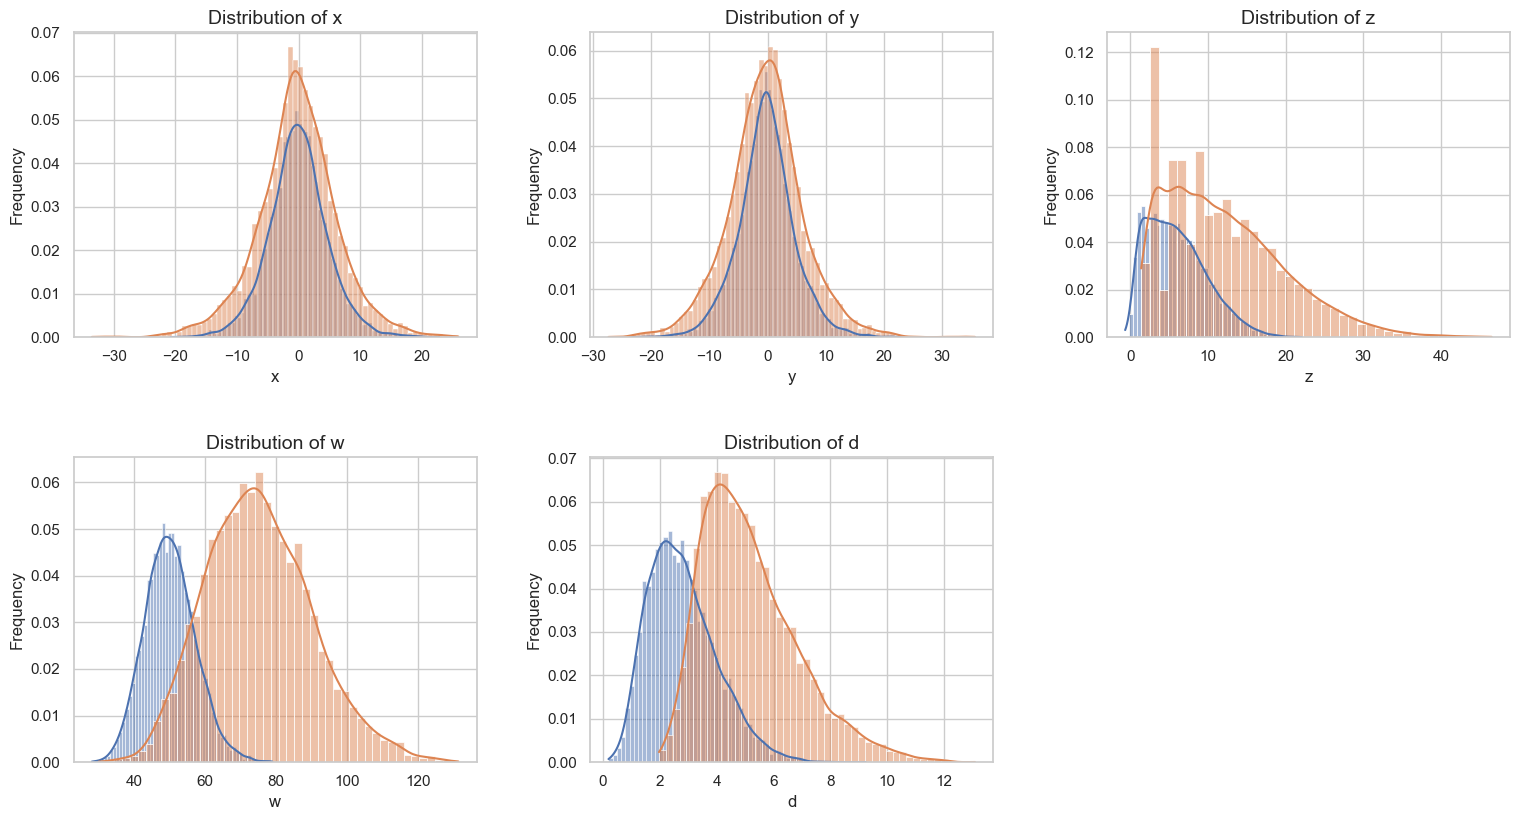

In [3]:

def create_histograms(data: pd.DataFrame, 
                      cols_to_plot:List[str]) -> None:
    """Creates and displays histograms for specified columns using seaborn."""
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
    axes_flat = axes.flatten()

    for t in ['A','B']:
        for i, col in enumerate(cols_to_plot):
            sns.histplot(data=data[data.type == t], x=col, ax=axes_flat[i], stat= 'probability',kde=True)
            axes_flat[i].set_title(f'Distribution of {col}', fontsize=14)
            axes_flat[i].set_xlabel(col, fontsize=12)
            axes_flat[i].set_ylabel('Frequency', fontsize=12)

    # Hide any unused subplots
    for i in range(len(cols_to_plot), len(axes_flat)):
        fig.delaxes(axes_flat[i])
        
    plt.tight_layout(pad=3.0)
    plt.show()

cols_to_plot= ['x', 'y', 'z', 'w', 'd']
create_histograms(df, cols_to_plot)

In [4]:
import pandas as pd

def summarize_events(data: pd.DataFrame) -> pd.DataFrame:
    """Groups data by event_id and calculates summary statistics for each event."""
    # Ensure the required columns exist to avoid KeyErrors
    required_cols = ['event_id', 'x', 'y', 'z', 'w', 'd']
    if not all(col in data.columns for col in required_cols):
        raise ValueError(f"Input DataFrame must contain the columns: {required_cols}")

    # Group by 'event_id' and apply aggregation functions
    # .agg() with named aggregation is used for clarity and direct column naming
    summary_df = data.groupby(['event_id','type']).agg(
        x_mean=('x', 'mean'),
        y_mean=('y', 'mean'),
        z_mean=('z', 'mean'),
        w_sum=('w', 'sum'),
        d_sum=('d', 'sum'),
        n_entries=('event_id', 'size')
    )

    return summary_df

event_df = summarize_events(df).reset_index()
event_df.head()

,event_id,type,x_mean,y_mean,z_mean,w_sum,d_sum,n_entries
0,0,A,2.087837,-6.155268,3.716373,259.936121,14.256049,5
1,0,B,-3.304325,3.642608,8.767359,361.402473,26.905382,5
2,1,A,0.734995,4.837776,4.659454,484.591005,32.453642,10
3,1,B,5.060159,-0.015344,4.818001,155.501223,10.588433,2
4,2,A,-6.755590,-6.473065,4.419191,492.829543,29.774711,9


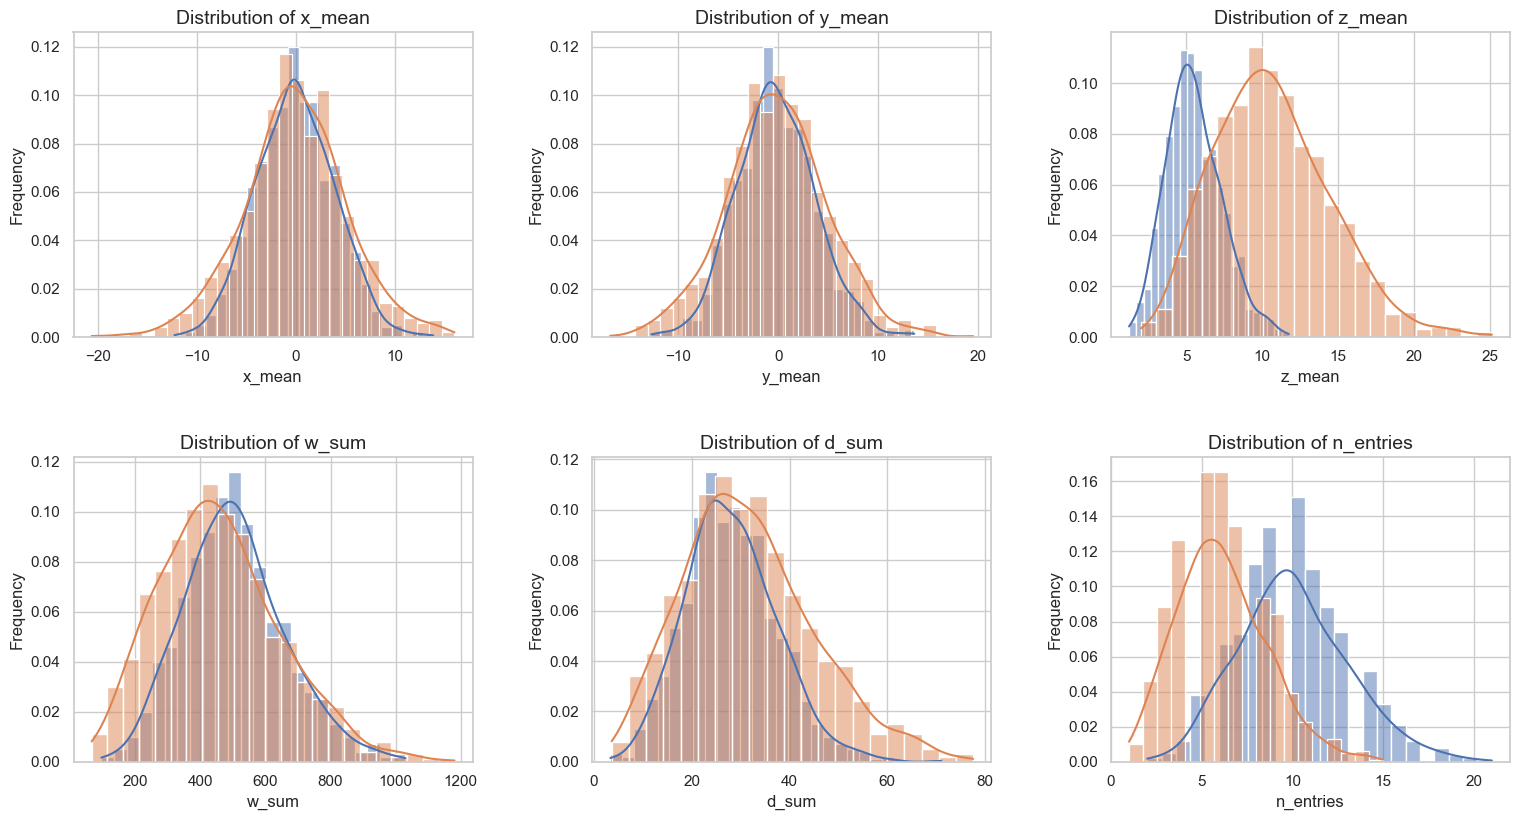

In [5]:
cols_to_plot= ['x_mean', 'y_mean', 'z_mean', 'w_sum', 'd_sum', 'n_entries']
create_histograms(event_df, cols_to_plot)

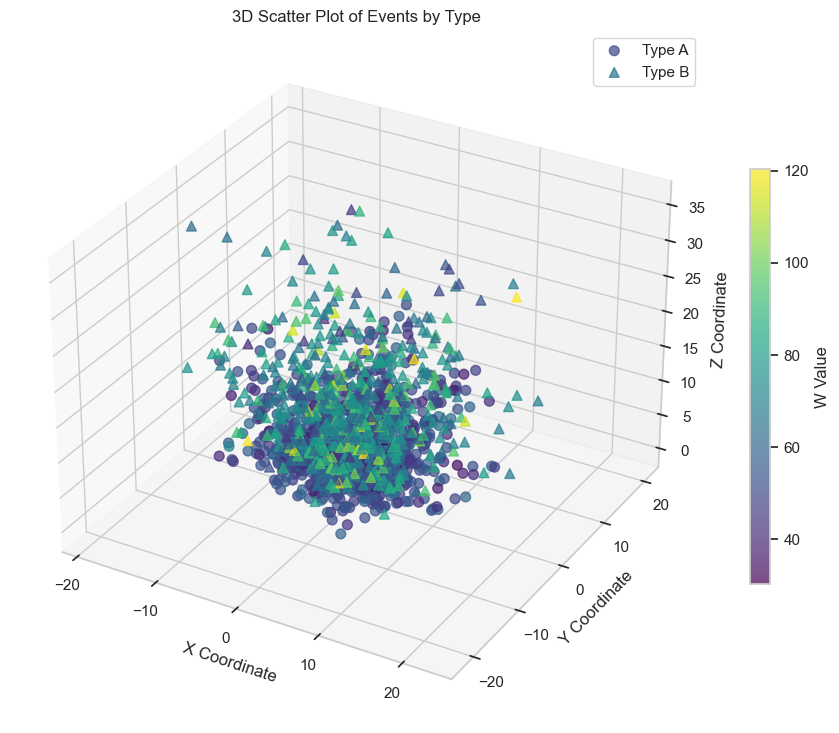

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter_matplotlib(data: pd.DataFrame) -> None:
    """Creates a 3D scatter plot with markers by type and color by 'w'."""
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    event_types = data['type'].unique()
    markers = ['o', '^', 's', 'P', 'X', 'D'] # Circles, triangles, squares...
    
    # Normalize color scale across all data points
    w_min = data['w'].min()
    w_max = data['w'].max()

    plot_object = None # To hold one of the plot outputs for the colorbar

    for i, event_type in enumerate(event_types):
        subset = data[data['type'] == event_type]
        marker_style = markers[i % len(markers)]
        
        plot_object = ax.scatter(
            xs=subset['x'],
            ys=subset['y'],
            zs=subset['z'],
            c=subset['w'],
            cmap='viridis',
            marker=marker_style,
            label=f'Type {event_type}',
            s=50, # Marker size
            alpha=0.7,
            vmin=w_min, # Ensure consistent color scale
            vmax=w_max
        )

    # Labeling and legends
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title('3D Scatter Plot of Events by Type')
    ax.legend()
    
    # Add a color bar to show the mapping from 'w' to color
    if plot_object:
        cbar = fig.colorbar(plot_object, ax=ax, shrink=0.6, aspect=20)
        cbar.set_label('W Value')

    plt.show()

plot_3d_scatter_matplotlib(df[df.event_id < 100])

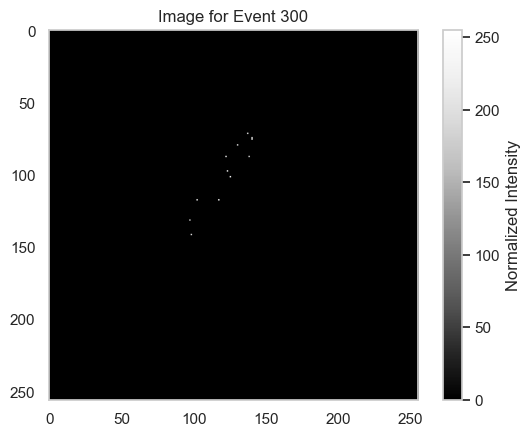

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple

def create_event_images(
    data: pd.DataFrame,
    image_size: Tuple[int, int] = (256, 256)
) -> Dict[int, np.ndarray]:
    """Converts event data into 2D images by mapping (x,y) to pixels and w to intensity."""
    images: Dict[int, np.ndarray] = {}
    img_height, img_width = image_size

    # Step 1: Determine global boundaries for a consistent mapping
    x_min, x_max = data['x'].min(), data['x'].max()
    y_min, y_max = data['y'].min(), data['y'].max()

    # Handle edge case where a dimension has no range (all values are the same)
    x_range = x_max - x_min if x_max > x_min else 1
    y_range = y_max - y_min if y_max > y_min else 1

    # Step 2: Group data by event and process each one
    for event_id, event_df in data.groupby('event_id'):
        if event_df.empty:
            continue

        # Extract columns as numpy arrays for performance
        x_coords = event_df['x'].values
        y_coords = event_df['y'].values
        w_values = event_df['w'].values

        # Step 3: Map world coordinates to pixel indices
        # Normalize coordinates to [0, 1]
        x_norm = (x_coords - x_min) / x_range
        y_norm = (y_coords - y_min) / y_range

        # Scale to image dimensions and cast to integer indices
        # We use img_width-1 because indices are 0-based (0 to 255)
        col_indices = (x_norm * (img_width - 1)).astype(np.int32)
        row_indices = (y_norm * (img_height - 1)).astype(np.int32)
        
        # Clip values to ensure they are within the valid index range [0, dim-1]
        col_indices = np.clip(col_indices, 0, img_width - 1)
        row_indices = np.clip(row_indices, 0, img_height - 1)

        # Step 4: Create image and aggregate intensities
        image_canvas = np.zeros(image_size, dtype=np.float32)
        
        # np.add.at is a highly efficient way to sum values at specific indices.
        # It correctly handles multiple points mapping to the same pixel.
        np.add.at(image_canvas, (row_indices, col_indices), w_values)
        
        images[event_id] = image_canvas

    return images

def normalize_for_display(image: np.ndarray) -> np.ndarray:
    """Normalizes an image with arbitrary intensity to the [0, 255] range for display."""
    if image.max() == image.min():
        return np.zeros_like(image, dtype=np.uint8)
    
    # Normalize to [0, 1]
    normalized = (image - image.min()) / (image.max() - image.min())
    
    # Scale to [0, 255] and cast to integer type
    return (normalized * 255).astype(np.uint8)

# --- Example Usage ---
#
# 1. Generate the source data (using a previously defined function)
# toy_data = generate_toy_data_with_steps(PARAMS)
#
# 2. Create the images from the data
event_images = create_event_images(df[df.type=='A'])

# 3. Display the image for a specific event (e.g., event 0)
i = 300
if  i in event_images:
    image_to_display = normalize_for_display(event_images[i])
    plt.imshow(image_to_display, cmap='Grays_r')
    plt.title(f"Image for Event {i}")
    plt.colorbar(label="Normalized Intensity")
    plt.grid(False)
    plt.show()



In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import Dict, Any, Tuple

# --- Data Generation (Unchanged) ---
PARAMS: Dict[str, Any] = {
    "n_events": 10000, "poisson_lam": 10.0,
    "xy_mean": np.array([5.0, 5.0]), "xy_cov": np.array([[2.0, 0.0], [0.0, 2.0]]),
    "z_mean": 1.0, "z_std": 0.5,
    "w_shape": 50.0, "w_scale": 1.0,
}

def generate_classifiable_toy_data(params: Dict[str, Any]) -> pd.DataFrame:
    """Generates data where event types have distinct spatial patterns."""
    rng = np.random.default_rng()
    all_events_data = []
    xy_mean_b = np.array([params["xy_mean"][0], -params["xy_mean"][1]])
    for event_id in range(params["n_events"]):
        n_i = rng.poisson(lam=params["poisson_lam"])
        if n_i == 0: continue
        event_type = rng.choice(['A', 'B'])
        current_xy_mean = params["xy_mean"] if event_type == 'A' else xy_mean_b
        xy_steps = rng.multivariate_normal(mean=current_xy_mean, cov=params["xy_cov"], size=n_i)
        w_values = rng.gamma(shape=params["w_shape"], scale=params["w_scale"], size=n_i)
        xy_path = np.cumsum(xy_steps, axis=0)
        event_df = pd.DataFrame({'event_id': event_id, 'x': xy_path[:, 0], 'y': xy_path[:, 1], 'w': w_values})
        event_df['event_type'] = event_type
        all_events_data.append(event_df)
    return pd.concat(all_events_data, ignore_index=True)

def create_event_images(data: pd.DataFrame, image_size: Tuple[int, int] = (256, 256)) -> Dict[int, np.ndarray]:
    """Converts event data into 2D images."""
    images: Dict[int, np.ndarray] = {}
    x_min, x_max = data['x'].min(), data['x'].max()
    y_min, y_max = data['y'].min(), data['y'].max()
    x_range = x_max - x_min if x_max > x_min else 1
    y_range = y_max - y_min if y_max > y_min else 1
    for event_id, event_df in data.groupby('event_id'):
        x_coords, y_coords, w_values = event_df['x'].values, event_df['y'].values, event_df['w'].values
        col_indices = np.clip(((x_coords - x_min) / x_range * (image_size[1] - 1)).astype(np.int32), 0, image_size[1] - 1)
        row_indices = np.clip(((y_coords - y_min) / y_range * (image_size[0] - 1)).astype(np.int32), 0, image_size[0] - 1)
        image_canvas = np.zeros(image_size, dtype=np.float32)
        np.add.at(image_canvas, (row_indices, col_indices), w_values)
        images[event_id] = image_canvas
    return images

# --- Data Preparation (Unchanged) ---
class EventImageDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray):
        self.images = torch.from_numpy(images).float().unsqueeze(1)
        self.labels = torch.from_numpy(labels).float().unsqueeze(1)
    def __len__(self) -> int: return len(self.images)
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]: return self.images[idx], self.labels[idx]

def prepare_data_for_torch(data: pd.DataFrame, images: Dict[int, np.ndarray]) -> Tuple[DataLoader, DataLoader]:
    event_type_map = data.drop_duplicates('event_id').set_index('event_id')['event_type']
    event_ids = list(images.keys())
    X_list = [images[eid] for eid in event_ids]
    y_list = [event_type_map[eid] for eid in event_ids]
    X = np.array(X_list)
    if X.max() > 0: X = X / X.max()
    y = LabelEncoder().fit_transform(y_list)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    train_loader = DataLoader(EventImageDataset(X_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(EventImageDataset(X_test, y_test), batch_size=32, shuffle=False)
    return train_loader, test_loader

# --- Model Architecture (Corrected and Robust) ---
class SimpleCNN(nn.Module):
    """A simple CNN with dynamically calculated layer sizes."""
    def __init__(self, input_shape: Tuple[int, int, int] = (1, 256, 256)):
        super(SimpleCNN, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        flattened_size = self._get_conv_output_size(input_shape)
        self.classifier_head = nn.Sequential(
            nn.Linear(flattened_size, 64), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1)
        )

    def _get_conv_output_size(self, shape: Tuple[int, int, int]) -> int:
        """Calculates the output size of the conv_base by running a dummy forward pass."""
        with torch.no_grad():
            dummy_input = torch.rand(1, *shape)
            output = self.conv_base(dummy_input)
        return int(np.prod(output.size()))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_base(x)
        x = x.view(x.size(0), -1) # Flatten the tensor dynamically
        x = self.classifier_head(x)
        return x

# --- Main Workflow (Unchanged) ---
def run_pytorch_classification_workflow():
    """Executes the full PyTorch workflow."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    print("Generating classifiable data...")
    classifiable_data = generate_classifiable_toy_data(PARAMS)
    event_images = create_event_images(classifiable_data)

    print("Preparing data for classifier...")
    train_loader, test_loader = prepare_data_for_torch(classifiable_data, event_images)

    print("Building the CNN model...")
    # Get the shape from a sample in the dataset to be fully robust
    sample_shape = next(iter(train_loader))[0].shape[1:]
    model = SimpleCNN(input_shape=sample_shape).to(device)
    print(model)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 5
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}")

    print("\nEvaluating the model on the test set...")
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return classifiable_data, event_images

cols = ['event_id', 'x', 'y','w', 'type']
data, images = run_pytorch_classification_workflow()

Using device: cuda
Generating classifiable data...
Preparing data for classifier...
Building the CNN model...
SimpleCNN(
  (conv_base): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_head): Sequential(
    (0): Linear(in_features=57600, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1/5, Training Loss: 0.1439
Epoch 2/5, Training Loss: 0.0002
Epoch 3/5, Training Loss: 0.0000
Epoch 4/5, Training Loss: 0.0001
Epoch 5/5, Training Loss

In [31]:
data.groupby('event_type').mean()

,event_id,x,y,w
event_type,,,,
A,494.004373,-0.041700,-0.215273,50.164507
B,500.256490,-0.158496,-0.269311,75.134983
